In [3]:
import os
import torch
import json
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.v2 import functional as F
import torchvision
from torchvision.transforms import v2
import supervision as sv
from torchvision.io import read_image
import sys
sys.path.append('./detection/')
import detr.util.misc as utils


In [4]:
import os
import json
import torch
from torchvision import transforms
from tqdm import tqdm

class pr_Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transforms=None):
        self.folder_path = folder_path
        self.transforms = transforms
        self.data_pairs = self._load_data_pairs()

    def _load_data_pairs(self):
        image_files = []
        json_files = {}
        data_pairs = []

        # 폴더를 재귀적으로 검색하여 이미지 파일과 JSON 파일 목록을 생성
        for root, _, files in os.walk(self.folder_path):
            for file in files:
                if file.endswith((".jpg", ".jpeg", ".png")):
                    image_files.append(os.path.join(root, file))
                elif file.endswith(".json"):
                    json_files[os.path.splitext(file)[0]] = os.path.join(root, file)

        # 진행률 표시줄 추가
        for image_file_path in tqdm(image_files, desc="Matching image and JSON files"):
            # 이미지 파일 이름에서 확장자를 제외한 부분 가져오기
            image_name = os.path.splitext(os.path.basename(image_file_path))[0]
        
            # 해당 이미지 파일과 매칭되는 JSON 파일 찾기
            if image_name in json_files:
                json_file_path = json_files[image_name]
                data_pairs.append((image_file_path, json_file_path))
            else:
                print(f"JSON file not found for image: {image_file_path}")
        
        return data_pairs

    def __getitem__(self, index):
        img_path, json_path = self.data_pairs[index]

        with open(json_path, 'r') as f:
            json_data = json.load(f)

        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        annotations = json_data['annotations']
        categories = json_data['categories']
        height = 1960  # 로즈 테스트시 고정값 사용
        width = float(json_data['images'][0]['width'])

        bbox = annotations[0]['bbox']
        bbox = (bbox[1], height - (bbox[0] + bbox[2]), bbox[1] + bbox[3], height - bbox[0])
        bbox = torch.tensor(bbox, dtype=torch.float32)
        obj_name = categories[annotations[0]['category_id']]['name']
        
        # 라벨을 숫자로 매핑
        label_mapping = {'화방': 3, '줄기': 1, '잎': 2, '열매': 4}
        label = label_mapping.get(obj_name, 0)
        label = torch.tensor(label, dtype=torch.int64)
        target = {"boxes": bbox, 
            
                "labels": label}

        return img, target
  
    def __len__(self):
        return len(self.data_pairs)

# # 사용 예시
# folder_path = "D:\\NOA\\시설작물모델\\data\\Validation"
# transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
# dataset = pr_Dataset(folder_path, transforms=transform)
# print(f"Dataset size: {len(dataset)}")


In [5]:
folder_path = "./Dataset"
# 데이터셋 객체 생성
dataset1 = pr_Dataset(folder_path)

# 데이터셋의 첫 번째 샘플에 대한 타겟 정보 확인
sample_img, sample_target = dataset1[10]
# 타겟의 모양과 유형을 출
print("target:", sample_target)
print("shape of target:", sample_target['boxes'].shape)

print("img:", sample_img)
print("Type of img:", type(sample_img))

print(sample_target["labels"])

Matching image and JSON files: 100%|██████████| 411/411 [00:00<00:00, 205514.90it/s]

target: {'boxes': tensor([2069.5400,  824.5400, 3963.1399, 1035.6600]), 'labels': tensor(1)}
shape of target: torch.Size([4])
img: <PIL.Image.Image image mode=RGB size=4032x1960 at 0x26B72C74850>
Type of img: <class 'PIL.Image.Image'>
tensor(1)


In [5]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ConvertImageDtype(torch.float32))
    transforms.append(T.ToTensor())
    return T.Compose(transforms)


In [7]:
sys.path.append('./detection')
import utils

from torch.utils.data import DataLoader
import sys

folder_path = "./Dataset"

num_classes = 4
# 데이터셋과 정의된 변환을 사용합니다
dataset = pr_Dataset(folder_path, get_transform(train=True))


# 데이터셋을 훈련 세트와 테스트 세트로 나눕니다
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset, indices[-100:])


# 훈련 및 검증 데이터 로더를 정의합니다
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    # num_workers=4,
    collate_fn=utils.collate_fn
  
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
    # num_workers=4,
)

Matching image and JSON files: 100%|██████████| 411/411 [00:00<00:00, 206227.89it/s]


In [8]:
len(data_loader)
len(data_loader_test)

100

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

#### "facebook/detr-resnet-50"


In [11]:
import torch.optim as optim
from transformers import DetrImageProcessor, DetrForObjectDetection


# 모델 불러오기
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model.to(device)

num_classes = 2

In [12]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.005,
    weight_decay=0.0005
)

In [13]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [16]:
import math


import torch.nn.functional as F

def update(self, **kwargs):
    for k, v in kwargs.items():
        if isinstance(v, torch.Tensor):
            if v.numel() == 1:  # 텐서가 스칼라인지 확인
                v = v.item()
            else:
                v = v.mean().item()  # 텐서가 스칼라가 아닌 경우, 평균값을 사용
        self.meters[k].update(v)


def compute_loss(output, targets):
    # 모델 출력에서 박스 예측과 클래스 예측 추출
    predicted_boxes = output["pred_boxes"]
    predicted_labels = output["pred_labels"]
    
    # 타겟에서 박스와 클래스 추출
    target_boxes = [target["boxes"] for target in targets]
    target_labels = [target["labels"] for target in targets]
    
    # 손실 계산
    loss_boxes = F.mse_loss(predicted_boxes, target_boxes)
    loss_labels = F.cross_entropy(predicted_labels, torch.cat(target_labels))
    
    # 전체 손실 반환
    return loss_boxes + loss_labels

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    # 모델을 학습 모드로 설정합니다.
    model.train()
    
    # 메트릭 로거를 초기화합니다.
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"
    
    # 첫 번째 에포크일 경우, 선형 학습률 스케줄러를 초기화합니다.
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # 데이터로더를 통해 반복하면서 학습을 수행합니다.
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # 이미지를 GPU로 이동합니다.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        # DetrImageProcessor를 사용하여 이미지와 타겟을 모델의 입력 형식으로 변환합니다.
        inputs = processor(images=images, return_tensors="pt").to(device)

        # Mixed precision 사용 여부에 따라 자동형변환을 활성화하고 손실을 계산합니다.
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(**inputs)

       # 모든 GPU에 대한 손실을 줄입니다.
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss.mean() for loss in loss_dict_reduced.values())

        # 손실 값이 유효한지 확인합니다.
        loss_value = losses_reduced.item()
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        # loss_dict_reduced를 스칼라 값으로 변환합니다.
        loss_dict_reduced = {k: v.mean().item() if isinstance(v, torch.Tensor) and v.numel() > 1 else v.item() for k, v in loss_dict_reduced.items()}

        # 그래디언트를 초기화하고 역전파를 수행합니다.
        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses_reduced).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses_reduced.backward()
            optimizer.step()

        # 학습률 스케줄러를 업데이트합니다.
        if lr_scheduler is not None:
            lr_scheduler.step()

        # 메트릭 로거를 업데이트합니다.
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        
    return metric_logger


In [17]:
# 학습 
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
print("학습이 끝났습니다!")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch: [0]  [  0/311]  eta: 0:20:01  lr: 0.000021  loss: -6.8861 (-6.8861)  logits: -7.2548 (-7.2548)  pred_boxes: 0.3257 (0.3257)  last_hidden_state: 0.0487 (0.0487)  encoder_last_hidden_state: -0.0057 (-0.0057)  time: 3.8637  data: 0.1395  max mem: 630
Epoch: [0]  [ 10/311]  eta: 0:05:25  lr: 0.000182  loss: -10.4113 (-9.8847)  logits: -10.9317 (-10.3161)  pred_boxes: 0.3622 (0.3749)  last_hidden_state: 0.0647 (0.0630)  encoder_last_hidden_state: -0.0057 (-0.0065)  time: 1.0811  data: 0.1404  max mem: 794
Epoch: [0]  [ 20/311]  eta: 0:04:32  lr: 0.000343  loss: -13.2996 (-12.2484)  logits: -13.5747 (-12.5524)  pred_boxes: 0.2139 (0.2509)  last_hidden_state: 0.0647 (0.0644)  encoder_last_hidden_state: -0.0115 (-0.0113)  time: 0.7908  data: 0.1395  max mem: 794
Epoch: [0]  [ 30/311]  eta: 0:04:08  lr: 0.000504  loss: -16.3436 (-13.7950)  logits: -16.4169 (-14.0168)  pred_boxes: 0.0333 (0.1748)  last_hidden_state: 0.0650 (0.0647)  encoder_last_hidden_state: -0.0247 (-0.0178)  time: 0.77

In [19]:
from torchvision.transforms import ToPILImage
to_pil_image = ToPILImage()

def visualize_predictions(model, data_loader, device, processor):
    model.eval()
    images, targets = next(iter(data_loader))
    images = [image.to(device) for image in images]
    inputs = processor(images=images, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    for i, image in enumerate(images):
        plt.figure(figsize=(10, 10))
        plt.imshow(to_pil_image(image.cpu()))
        
        boxes = outputs.pred_boxes[i].cpu()
        logits = outputs.logits[i].cpu()
        scores = logits.softmax(-1)
        labels = scores.argmax(-1)
        
        for box, score, label in zip(boxes, scores, labels):
            if score[label] > 0.5:
                x_min, y_min, x_max, y_max = box
                plt.gca().add_patch(
                    plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=3)
                )
                plt.text(x_min, y_min, f'{label.item()}: {score[label]:.2f}', fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
        
        plt.axis('off')
        plt.show()


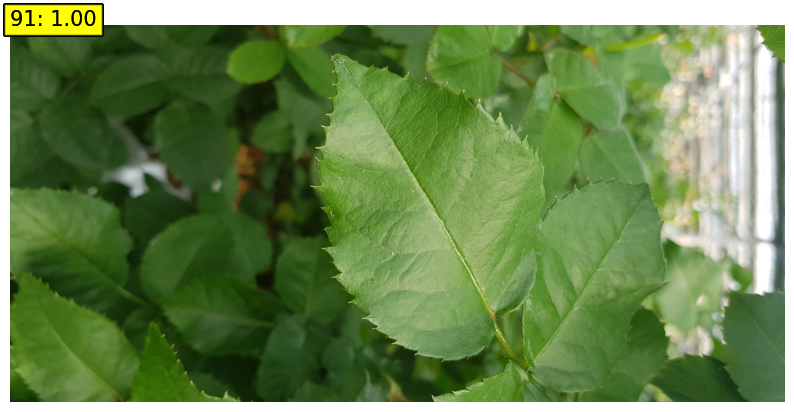

In [20]:
visualize_predictions(model, data_loader_test, device, processor)